In [1]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1lTZZA41mpHChH2gXuMwSA5DHSqAb6fJH'})
download.GetContentFile('PlantVillage-Dataset.tar')

In [0]:
!tar -xf PlantVillage-Dataset.tar

In [6]:
batch_size = 96
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

train_generator = datagen.flow_from_directory(
        'PlantVillage-Dataset/raw/color',
        subset='training',
        target_size=(128, 128),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

val_generator = datagen.flow_from_directory(
        'PlantVillage-Dataset/raw/color',
        subset='validation',
        target_size=(128, 128),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [0]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import tensorflow as tf

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
sample_training_images, _ = next(train_generator)

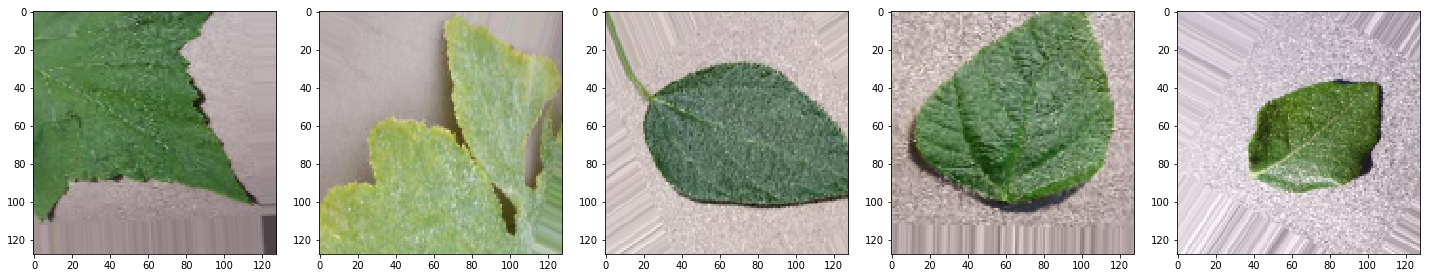

In [10]:
plotImages(sample_training_images[:5])

In [0]:
!mkdir preview

In [0]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
img = load_img('PlantVillage-Dataset/raw/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='plant', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

preview/plant_0_7822.jpeg
preview/plant_0_6145.jpeg
preview/plant_0_7915.jpeg
preview/plant_0_9921.jpeg
preview/plant_0_4291.jpeg
preview/plant_0_4285.jpeg


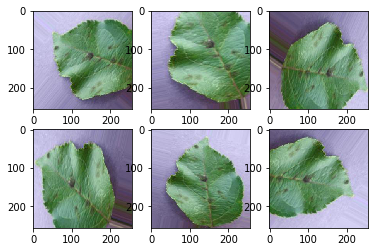

In [13]:
import matplotlib.image as mpimg
plt.figure()
currentFolder = 'preview/'
for i, file in enumerate(os.listdir(currentFolder)[0:6]):
    fullpath = currentFolder + file
    print(fullpath)
    img=mpimg.imread(fullpath)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)

In [14]:
pre_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(128,128,3), alpha=1.0, include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step


In [0]:
for layer in pre_model.layers:
    layer.trainable = False

In [0]:
model_fine = tf.keras.models.Sequential()

In [0]:
model_fine.add(pre_model)

In [0]:
model_fine.add(tf.keras.layers.Flatten())

In [19]:
model_fine.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l1(0.001), activation='relu'))
model_fine.add(tf.keras.layers.Dropout(0.4))
model_fine.add(tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l1(0.001), activation='relu'))
model_fine.add(tf.keras.layers.Dropout(0.4))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_fine.add(tf.keras.layers.Dense(38, activation='softmax'))

In [21]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total para

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001,), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
history = model_fine.fit_generator(train_generator,validation_data=val_generator,epochs=23,steps_per_epoch=20, validation_steps=114)

Instructions for updating:
Use tf.cast instead.
Epoch 1/23
453/453 [==============================] - 330s 728ms/step - loss: 80.8504 - categorical_accuracy: 0.6250 - val_loss: 24.7476 - val_categorical_accuracy: 0.3689
Epoch 2/23
453/453 [==============================] - 323s 714ms/step - loss: 14.5638 - categorical_accuracy: 0.7185 - val_loss: 11.6691 - val_categorical_accuracy: 0.3384
Epoch 3/23
453/453 [==============================] - 321s 709ms/step - loss: 8.3868 - categorical_accuracy: 0.7044 - val_loss: 8.2464 - val_categorical_accuracy: 0.3216
Epoch 4/23
453/453 [==============================] - 318s 702ms/step - loss: 5.7488 - categorical_accuracy: 0.7124 - val_loss: 6.1346 - val_categorical_accuracy: 0.3826
Epoch 5/23
453/453 [==============================] - 316s 698ms/step - loss: 4.2710 - categorical_accuracy: 0.7140 - val_loss: 5.2333 - val_categorical_accuracy: 0.3248
Epoch 6/23
453/453 [==============================] - 320s 707ms/step - loss: 3.4987 - categorical

In [24]:
model_fine.evaluate_generator(val_generator)

[3.9820662318614493, 0.35763666]

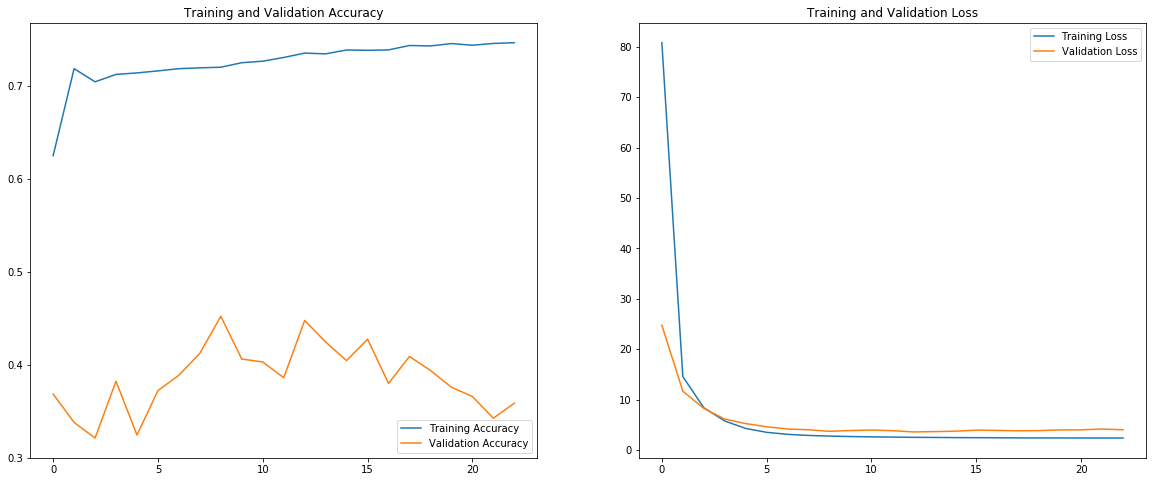

In [25]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model_fine.save("PlantKeras-23-transfer-epoch-l1-001-drpt-04-lr0001.h5")

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'PlantKeras-23-transfer-epoch-l1-001-drpt-04-lr0001.h5'})
upload.SetContentFile('PlantKeras-23-transfer-epoch-l1-001-drpt-04-lr0001.h5')
upload.Upload()

In [30]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_15_add')

In [0]:
for layer in pre_model.layers:
    layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total para

In [36]:
history = model_fine.fit_generator(train_generator,validation_data=val_generator,epochs=23,steps_per_epoch=20, validation_steps=114)

Epoch 1/23
453/453 [==============================] - 341s 753ms/step - loss: 1.9851 - categorical_accuracy: 0.7922 - val_loss: 3.4283 - val_categorical_accuracy: 0.4466
Epoch 2/23
453/453 [==============================] - 341s 753ms/step - loss: 1.6027 - categorical_accuracy: 0.8333 - val_loss: 3.5106 - val_categorical_accuracy: 0.4076
Epoch 3/23
453/453 [==============================] - 336s 742ms/step - loss: 1.4587 - categorical_accuracy: 0.8482 - val_loss: 3.6225 - val_categorical_accuracy: 0.3568
Epoch 4/23
453/453 [==============================] - 337s 743ms/step - loss: 1.3562 - categorical_accuracy: 0.8626 - val_loss: 3.3193 - val_categorical_accuracy: 0.4391
Epoch 5/23
453/453 [==============================] - 335s 740ms/step - loss: 1.2745 - categorical_accuracy: 0.8753 - val_loss: 3.4179 - val_categorical_accuracy: 0.3997
Epoch 6/23
453/453 [==============================] - 332s 734ms/step - loss: 1.2331 - categorical_accuracy: 0.8786 - val_loss: 3.4394 - val_categoric

In [37]:
model_fine.evaluate_generator(val_generator)

[3.3686439917798627, 0.34224352]

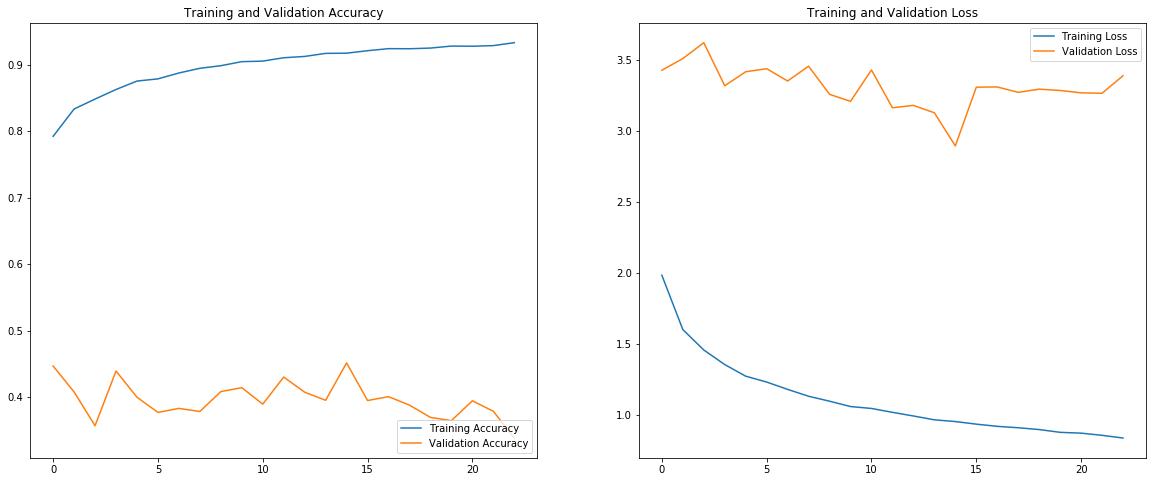

In [38]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model_fine.save("PlantKeras-23-finetune_1-epoch-l1-001-drpt-04-0001.h5")

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'PlantKeras-23-finetune_1-epoch-l1-001-drpt-04-0001.h5'})
upload.SetContentFile('PlantKeras-23-finetune_1-epoch-l1-001-drpt-04-0001.h5')
upload.Upload()

In [42]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_13_expand')

In [0]:
for layer in pre_model.layers:
    layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [47]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total para

In [48]:
history = model_fine.fit_generator(train_generator,validation_data=val_generator,epochs=23,steps_per_epoch=20, validation_steps=114)

Epoch 1/23
453/453 [==============================] - 343s 758ms/step - loss: 0.5405 - categorical_accuracy: 0.9383 - val_loss: 3.0837 - val_categorical_accuracy: 0.3461
Epoch 2/23
453/453 [==============================] - 339s 747ms/step - loss: 0.4775 - categorical_accuracy: 0.9384 - val_loss: 3.1511 - val_categorical_accuracy: 0.3364
Epoch 3/23
453/453 [==============================] - 337s 745ms/step - loss: 0.4579 - categorical_accuracy: 0.9397 - val_loss: 3.1955 - val_categorical_accuracy: 0.3309
Epoch 4/23
453/453 [==============================] - 337s 744ms/step - loss: 0.4517 - categorical_accuracy: 0.9395 - val_loss: 3.1640 - val_categorical_accuracy: 0.3280
Epoch 5/23
453/453 [==============================] - 355s 783ms/step - loss: 0.4437 - categorical_accuracy: 0.9394 - val_loss: 3.1899 - val_categorical_accuracy: 0.3249
Epoch 6/23
453/453 [==============================] - 355s 785ms/step - loss: 0.4377 - categorical_accuracy: 0.9412 - val_loss: 3.2041 - val_categoric

In [49]:
model_fine.evaluate_generator(val_generator)

[3.1717680295308432, 0.32205734]

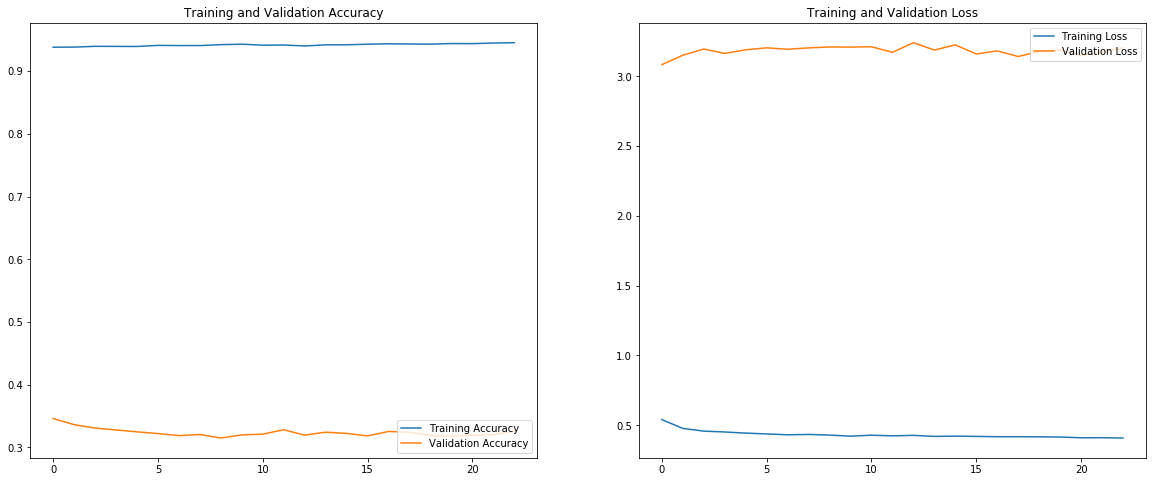

In [50]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
model_fine.save("PlantKeras-23-finetune_2-epoch-l1-001-drpt-04-lr000001.h5")

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'PlantKeras-23-finetune_2-epoch-l1-001-drpt-04-lr000001.h5'})
upload.SetContentFile('PlantKeras-23-finetune_2-epoch-l1-001-drpt-04-lr000001.h5')
upload.Upload()

In [54]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_8_expand')

for layer in pre_model.layers:
    layer.trainable = True

all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [57]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total para

In [58]:
history = model_fine.fit_generator(train_generator,validation_data=val_generator,epochs=23,steps_per_epoch=20, validation_steps=114)

Epoch 1/23
453/453 [==============================] - 358s 789ms/step - loss: 0.4062 - categorical_accuracy: 0.9443 - val_loss: 3.1216 - val_categorical_accuracy: 0.3338
Epoch 2/23
453/453 [==============================] - 355s 783ms/step - loss: 0.4037 - categorical_accuracy: 0.9460 - val_loss: 3.0702 - val_categorical_accuracy: 0.3407
Epoch 3/23
453/453 [==============================] - 349s 771ms/step - loss: 0.4051 - categorical_accuracy: 0.9447 - val_loss: 3.0636 - val_categorical_accuracy: 0.3460
Epoch 4/23
453/453 [==============================] - 345s 762ms/step - loss: 0.4022 - categorical_accuracy: 0.9464 - val_loss: 3.0407 - val_categorical_accuracy: 0.3529
Epoch 5/23
453/453 [==============================] - 344s 759ms/step - loss: 0.4067 - categorical_accuracy: 0.9426 - val_loss: 3.0140 - val_categorical_accuracy: 0.3533
Epoch 6/23
453/453 [==============================] - 344s 760ms/step - loss: 0.4051 - categorical_accuracy: 0.9457 - val_loss: 3.0404 - val_categoric

In [59]:
model_fine.evaluate_generator(val_generator)

[3.0650963971489356, 0.35957232]

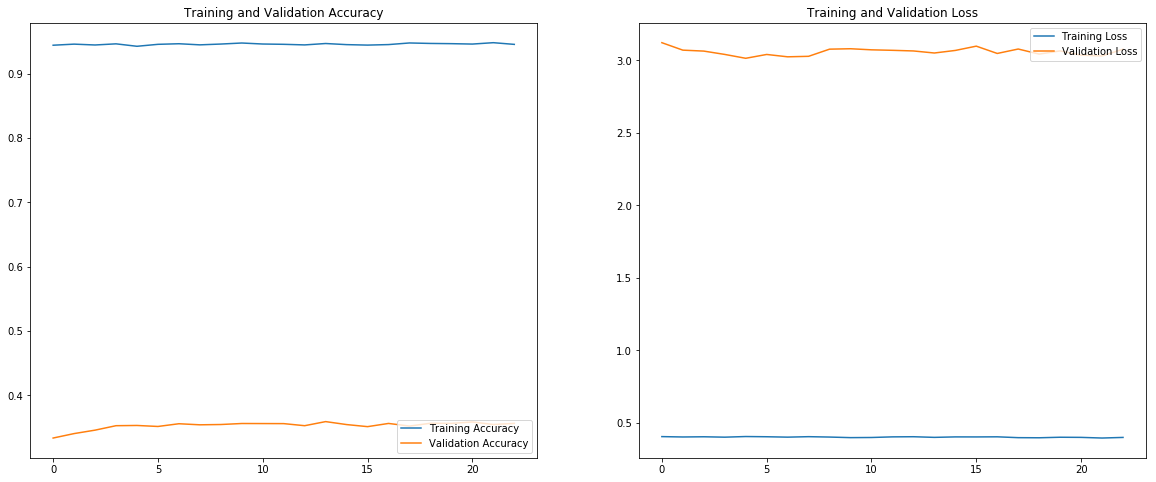

In [60]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
model_fine.save("PlantKeras-23-finetune_3-epoch-l1-001-drpt-04-lr0000001.h5")

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'PlantKeras-23-finetune_3-epoch-l1-001-drpt-04-lr0000001.h5'})
upload.SetContentFile('PlantKeras-23-finetune_3-epoch-l1-001-drpt-04-lr0000001.h5')
upload.Upload()

In [0]:
for layer in pre_model.layers:
    layer.trainable = True

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [66]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total para

In [67]:
history = model_fine.fit_generator(train_generator,validation_data=val_generator,epochs=23,steps_per_epoch=20, validation_steps=114)

Epoch 1/23
453/453 [==============================] - 397s 877ms/step - loss: 0.4028 - categorical_accuracy: 0.9461 - val_loss: 2.1730 - val_categorical_accuracy: 0.5126
Epoch 2/23
453/453 [==============================] - 389s 860ms/step - loss: 0.3997 - categorical_accuracy: 0.9461 - val_loss: 1.5224 - val_categorical_accuracy: 0.6555
Epoch 3/23
453/453 [==============================] - 386s 852ms/step - loss: 0.3997 - categorical_accuracy: 0.9458 - val_loss: 1.0939 - val_categorical_accuracy: 0.7431
Epoch 4/23
453/453 [==============================] - 394s 870ms/step - loss: 0.3988 - categorical_accuracy: 0.9474 - val_loss: 0.7908 - val_categorical_accuracy: 0.8236
Epoch 5/23
453/453 [==============================] - 395s 872ms/step - loss: 0.3976 - categorical_accuracy: 0.9483 - val_loss: 0.5998 - val_categorical_accuracy: 0.8794
Epoch 6/23
453/453 [==============================] - 396s 873ms/step - loss: 0.4020 - categorical_accuracy: 0.9457 - val_loss: 0.4862 - val_categoric

In [68]:
model_fine.evaluate_generator(val_generator)

[0.33164797984717187, 0.96340674]

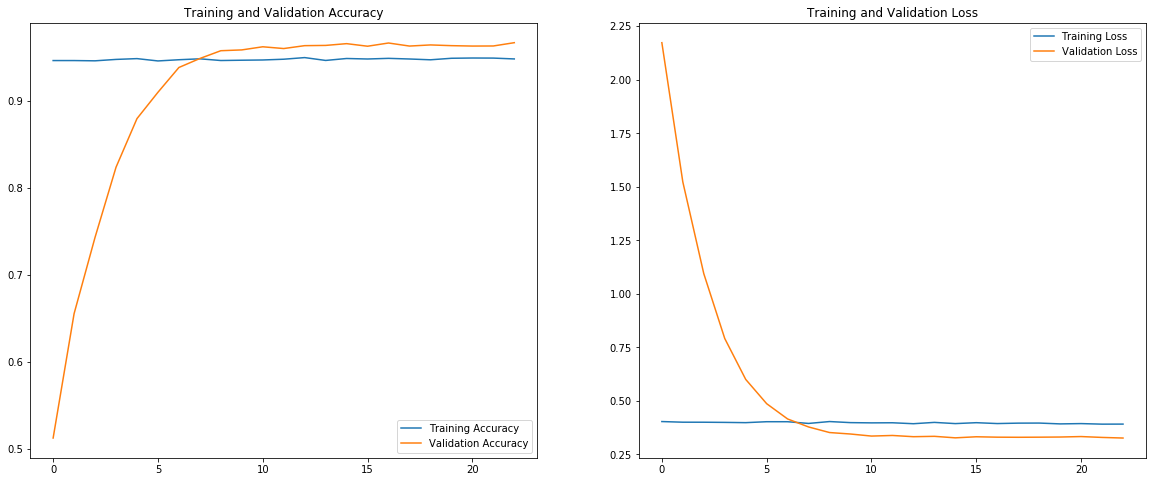

In [69]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
model_fine.save("PlantKeras-23-finetune_all-epoch-l1-001-drpt-04-lr0000001.h5")

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'PlantKeras-23-finetune_all-epoch-l1-001-drpt-04-lr0000001.h5'})
upload.SetContentFile('PlantKeras-23-finetune_all-epoch-l1-001-drpt-04-lr0000001.h5')
upload.Upload()